In [1]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nrelpy.atb import ATBe
from tqdm import tqdm

## Technology Data and Costs

As a first pass, we can use data curated by the PyPSA team for Europe in units of &euro;. Later, we can convert these to dollars or use data from NREL. The currency years will also need to be updated.

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

In [6]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [7]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [8]:
costs.head(2)

parameter,C in fuel,C stored,CO2 intensity,CO2 stored,FOM,Motor size,VOM,ammonia-input,c_b,c_v,capacity,capture rate,capture_rate,carbondioxide-input,carbondioxide-output,commodity,compression-electricity-input,compression-heat-output,discount rate,district heat surcharge,district heat-input,efficiency,efficiency-biomass,efficiency-electricity,efficiency-heat,efficiency-hydrogen,efficiency-tot,electricity-input,fuel,hbi-input,heat-input,heat-output,hydrogen-input,investment,lifetime,lohc-input,methane-input,methanol-input,min_fill_level,naphtha-input,nitrogen-input,ore-input,p_nom_ratio,pelletizing cost,marginal_cost,capital_cost
technology,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ammonia cracker,NaN,NaN,0.0,NaN,4.3000,NaN,0.0000,1.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,NaN,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.123945e+06,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,144775.985816
BEV Bus city,NaN,NaN,0.0,NaN,0.0003,346.5517,0.0952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,NaN,NaN,0.8585,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.224856e+05,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0952,28012.052635


In [14]:
costs.index.get_level_values('technology').unique().to_list()

['Ammonia cracker',
 'BEV Bus city',
 'BEV Coach',
 'BEV Truck Semi-Trailer max 50 tons',
 'BEV Truck Solo max 26 tons',
 'BEV Truck Trailer max 56 tons',
 'Battery electric (passenger cars)',
 'Battery electric (trucks)',
 'BioSNG',
 'BtL',
 'CCGT',
 'CH4 (g) fill compressor station',
 'CH4 (g) pipeline',
 'CH4 (g) submarine pipeline',
 'CH4 (l) transport ship',
 'CH4 evaporation',
 'CH4 liquefaction',
 'CO2 liquefaction',
 'CO2 pipeline',
 'CO2 storage tank',
 'CO2 submarine pipeline',
 'Charging infrastructure fast (purely) battery electric vehicles passenger cars',
 'Charging infrastructure fuel cell vehicles passenger cars',
 'Charging infrastructure fuel cell vehicles trucks',
 'Charging infrastructure slow (purely) battery electric vehicles passenger cars',
 'Compressed-Air-Adiabatic-bicharger',
 'Compressed-Air-Adiabatic-store',
 'Concrete-charger',
 'Concrete-discharger',
 'Concrete-store',
 'Container feeder, ammonia',
 'Container feeder, diesel',
 'Container feeder, methanol

## Retrieve Time Series Data

In [8]:
pjm_load = pd.read_csv("../data/pjm_demand.csv", usecols=['Interval End','CE'], parse_dates=True, index_col='Interval End')

In [9]:
pjm_load.head(2)

,CE
Interval End,
2019-01-01 00:00:00+00:00,11593.0
2019-01-01 01:00:00+00:00,11258.0


In [10]:
miso_load = pd.read_csv('../data/miso_demand.csv', usecols=['Interval End','0004'], parse_dates=True, index_col='Interval End')
miso_load.head(2)

,0004
Interval End,
2019-01-01 00:00:00+00:00,5406.0
2019-01-01 01:00:00+00:00,5289.0


In [11]:
load_year = 2022

pjm_2022 = pjm_load.loc[str(load_year)]
miso_2022 = miso_load.loc[str(load_year)]

### Upload the solar and wind data

In [12]:
pjm_wind = pd.read_csv("../data/nrel_wtk_data/ComEd_wind_2013.csv")
miso_wind = pd.read_csv("../data/nrel_wtk_data/MISO-Z4_wind_2013.csv")
pjm_solar = pd.read_csv("../data/nrel_psm_data/ComEd_solar_2019.csv")
miso_solar = pd.read_csv("../data/nrel_psm_data/MISO-Z4_solar_2019.csv")

## Process the solar and wind data

Since these data represent resources, rather than energy production, we should convert them to curves that would represent energy production.
Secondly, these curves should be normalized to a maximum value of unity (i.e., the $L_{\infty}$-norm), because PyPSA will multiply the power production by the corresponding values in `n.generators.p_nom_opt` (with units of power). 

### Solar

Technically, the solar production for a fixed-tilt solar panel is given by 

$\text{P}_{\text{pv}} = \text{P}_\text{GHI}\tau_{\text{pv}}\eta_{\text{ref}}\text{A}\left[1-\gamma(T-25)\right]$

Where 

- $\text{P}_\text{GHI}$ is the total incident power (i.e., global horizontal irradiance) in units of $\left[\frac{\text{W}}{\text{m}^2}\right]$. 
- $\tau$ is the "transmittance of the PV module's outside layer",
- $\gamma$ is the "temperature coefficient",
- $\text{A}$ is the area covered by the solar panels,
- $\eta$ is the PV module efficiency,
- $\text{T}$ is the temperature (in $^\circ\text{C}$)",

However, if we assume that temperature has no effect on panel performance, then the output power and incident power are linearly related. Which means the _shape_ of the power production is identical to the _shape_ of the insolation and therefore we can directly normalize to get hourly capacity factor.

### Wind

Wind, however, has a more complex relationship with its energy source. The output from a wind turbine is given by

$\text{P}_{\text{turbine}} = \frac{1}{2}\rho\text{A}v^3$

Additionally, wind turbines have various operating regimes.
- Cut-in speed, below which no power is produced.
- Rated speed, which follows the $v^3$ relationship.
- Cut-out speed, above which no power is produced.

So, we need data from NREL's ATB on these turbine parameters.


#### Determine the average wind speed for each zone

In [13]:
pjm_wind.describe()

,wind_speed_80m,wind_speed_100m
count,8760.000000,8760.000000
mean,6.529581,6.959604
std,2.894817,2.959452
min,0.050000,0.040000
25%,4.540000,4.770000
50%,6.560000,6.990000
75%,8.382500,9.020000
max,100.000000,18.820000


In [14]:
miso_wind.describe()

,wind_speed_80m,wind_speed_100m
count,8760.000000,8760.000000
mean,6.565737,6.994201
std,2.875684,3.147515
min,0.180000,0.160000
25%,4.457500,4.650000
50%,6.600000,6.930000
75%,8.590000,9.230000
max,20.330000,21.320000


#### Get turbine data

For now, we will use the following wind turbine assumptions, based on the [GE 2.75-103 wind turbine](https://en.wind-turbine-models.com/turbines/747-ge-general-electric-ge-2.75-103).

In [15]:
from unyt import m, s, MW, W, kg

In [16]:
cut_in = 3.0*m/s
cut_out = 25.0*m/s
rated = 13.0*m/s
diameter = 103*m
rated_power = 2.75*MW
air_density = 1.225*kg/m**3

In [17]:
power = lambda v: np.min((((0.5*np.pi/4)*(air_density*diameter**2)*v**3).to(MW), rated_power))*MW

In [18]:
power(8*m/s)

unyt_quantity(2.61300587, 'MW')

In [19]:
def turbine_power(v):
    """
    Calculates the power output of a wind turbine.
    
    Parameters
    ----------
    v : float
        Wind speed in meters per second (m/s).
    Returns
    -------
    power : float
        Power in megawatts (MW).
    """
    
    wind_speed = v*m/s
    
    if wind_speed < cut_in:
        return 0*MW
    elif (wind_speed > rated) and (wind_speed < cut_out):
        return rated_power
    elif wind_speed >= cut_out:
        return 0*MW
    elif wind_speed >= cut_in:
        return power(wind_speed)
    
    

In [20]:
miso_wind = miso_wind.assign(power_80m=miso_wind['wind_speed_80m'].apply(turbine_power),
                 power_100m=miso_wind['wind_speed_100m'].apply(turbine_power))
pjm_wind = pjm_wind.assign(power_80m=pjm_wind['wind_speed_80m'].apply(turbine_power),
                 power_100m=pjm_wind['wind_speed_100m'].apply(turbine_power))

<Axes: xlabel='wind_speed_80m'>

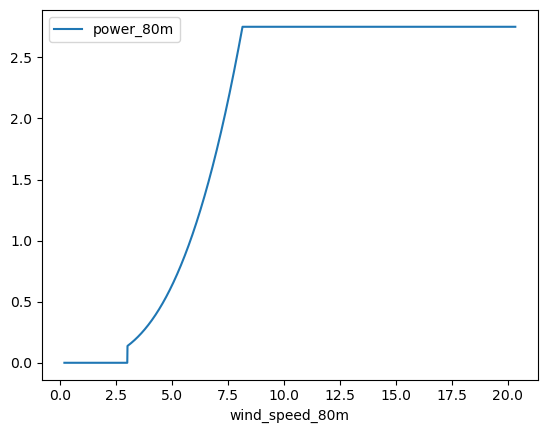

In [21]:
fig, ax = plt.subplots()

miso_wind.sort_values(by='wind_speed_80m').plot(ax=ax, x='wind_speed_80m',y='power_80m')

#### Normalize the Solar and Wind data

In [22]:
pjm_wind[['power_80m','power_100m']] = pjm_wind[['power_80m','power_100m']].div(pjm_wind[['power_80m','power_100m']].max(), axis=1)
miso_wind[['power_80m','power_100m']]= miso_wind[['power_80m','power_100m']].div(miso_wind[['power_80m','power_100m']].max(), axis=1)
pjm_solar['GHI_norm'] = pjm_solar['GHI']/pjm_solar['GHI'].max()
miso_solar['GHI_norm'] = miso_solar['GHI']/miso_solar['GHI'].max()

In [23]:
timestamps = pd.date_range("2022-01-01","2023-01-01", freq='1h', inclusive='left', tz='utc')
timestamps

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 01:00:00+00:00',
               '2022-01-01 02:00:00+00:00', '2022-01-01 03:00:00+00:00',
               '2022-01-01 04:00:00+00:00', '2022-01-01 05:00:00+00:00',
               '2022-01-01 06:00:00+00:00', '2022-01-01 07:00:00+00:00',
               '2022-01-01 08:00:00+00:00', '2022-01-01 09:00:00+00:00',
               ...
               '2022-12-31 14:00:00+00:00', '2022-12-31 15:00:00+00:00',
               '2022-12-31 16:00:00+00:00', '2022-12-31 17:00:00+00:00',
               '2022-12-31 18:00:00+00:00', '2022-12-31 19:00:00+00:00',
               '2022-12-31 20:00:00+00:00', '2022-12-31 21:00:00+00:00',
               '2022-12-31 22:00:00+00:00', '2022-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq='h')

In [24]:
for frame in tqdm([pjm_wind, miso_wind, pjm_solar, miso_solar]):
    frame.set_index(timestamps, inplace=True)

100%|██████████| 4/4 [00:00<00:00, 1538.35it/s]


### Update the resolution for simplicity

In [25]:
resolution = 4
pjm_2022 = pjm_2022.resample(f"{resolution}h").mean()
miso_2022 = miso_2022.resample(f"{resolution}h").mean()
pjm_solar = pjm_solar.resample(f"{resolution}h").mean()
miso_solar = miso_solar.resample(f"{resolution}h").mean()
pjm_wind = pjm_wind.resample(f"{resolution}h").mean()
miso_wind = miso_wind.resample(f"{resolution}h").mean()

## Capacity Expansion Model

### Model Initialization

In [26]:
n = pypsa.Network()

Add two buses -- PJM ComEd and Miso Zone 4

In [27]:
n.add("Bus", "MISO-Z4")
n.add("Bus", "ComEd")

In [28]:
n.buses.index

Index(['MISO-Z4', 'ComEd'], dtype='object', name='Bus')

In [29]:
n.set_snapshots(pjm_2022.index)

In [30]:
n.snapshots

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 04:00:00+00:00',
               '2022-01-01 08:00:00+00:00', '2022-01-01 12:00:00+00:00',
               '2022-01-01 16:00:00+00:00', '2022-01-01 20:00:00+00:00',
               '2022-01-02 00:00:00+00:00', '2022-01-02 04:00:00+00:00',
               '2022-01-02 08:00:00+00:00', '2022-01-02 12:00:00+00:00',
               ...
               '2022-12-30 08:00:00+00:00', '2022-12-30 12:00:00+00:00',
               '2022-12-30 16:00:00+00:00', '2022-12-30 20:00:00+00:00',
               '2022-12-31 00:00:00+00:00', '2022-12-31 04:00:00+00:00',
               '2022-12-31 08:00:00+00:00', '2022-12-31 12:00:00+00:00',
               '2022-12-31 16:00:00+00:00', '2022-12-31 20:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='snapshot', length=2190, freq='4h')

In [31]:
n.snapshot_weightings.loc[:,:] = resolution  # how many hours each timeslice represents, based on the temporal resolution

In [32]:
carriers = [
    "onwind",
    # "offwind",
    "nuclear",
    "solar",
    "OCGT",
    "CCGT",
    "coal",
    "hydrogen storage underground",
    "battery storage"
]

colors = {"onwind":'dodgerblue',
          "offwind":"aquamarine",
          "nuclear":"green",
          "solar":"gold",
          "OCGT":"indianred",
          "CCGT":"orange",
          "coal":"brown",
          "hydrogen storage underground":"magenta",
          "battery storage":"yellowgreen"}

n.madd(
    "Carrier",
    carriers,
    color=[colors[c] for c in carriers],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'nuclear', 'solar', 'OCGT', 'CCGT', 'coal',
       'hydrogen storage underground', 'battery storage'],
      dtype='object')

Add the load to the buses

In [33]:
n.add(
    "Load",
    "pjm_load",
    bus='ComEd',
    p_set = pjm_2022['CE']
)

n.add(
    "Load",
    "miso_load",
    bus='MISO-Z4',
    p_set = miso_2022['0004']
)

<Axes: xlabel='snapshot', ylabel='MW'>

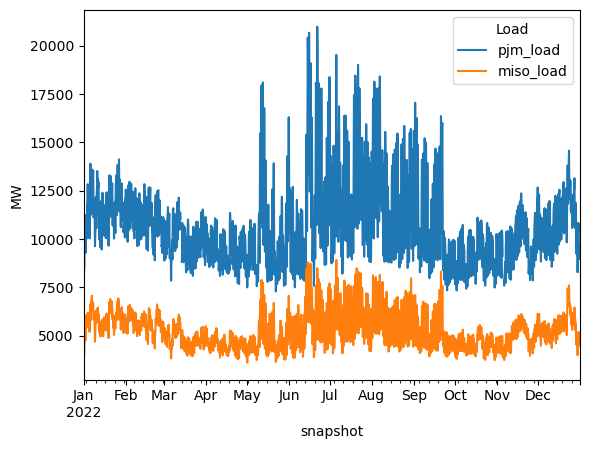

In [34]:
n.loads_t.p_set.plot(ylabel='MW')

## Adding generators to the model

In [35]:
buses = ['ComEd','MISO-Z4']
for tech in ['nuclear','OCGT','CCGT','coal']:
    n.madd(
        "Generator",
        buses,
        suffix=f" {tech}",
        bus=buses,
        carrier=tech,
        capital_cost=costs.at[tech, "capital_cost"],
        marginal_cost=costs.at[tech, "marginal_cost"],
        efficiency=costs.at[tech, "efficiency"],
        p_nom_extendable=True,
    )

In [36]:
for tech in ['onwind','solar']:
    for bus in buses:
        if (bus == 'ComEd') and (tech=='solar'):
            ts = pjm_solar['GHI_norm']
        elif (bus == 'ComEd') and (tech=='onwind'):
            ts = pjm_wind['power_80m']
        elif (bus == 'MISO-Z4') and (tech=='solar'):
            ts = miso_solar['GHI_norm']
        elif (bus == 'MISO-Z4') and (tech=='onwind'):
            ts = miso_wind['power_80m']
        n.add(
            class_name = "Generator",
            name = f"{bus} {tech}",
            bus=bus,
            carrier=tech,
            p_max_pu = ts,
            capital_cost=costs.at[tech, "capital_cost"],
            marginal_cost=costs.at[tech, "marginal_cost"],
            efficiency=costs.at[tech, "efficiency"],
            p_nom_extendable=True,
        )

<Axes: xlabel='snapshot', ylabel='CF'>

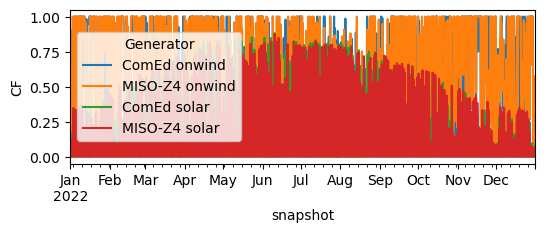

In [37]:
n.generators_t.p_max_pu.plot(figsize=(6, 2), ylabel="CF")

In [38]:
n.optimize(solver_name='highs')

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\linopy\common.py:133: UserWarning:

coords for dimension(s) ['snapshot'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 59.43it/s]
INFO:linopy.io: Writing time: 0.25s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26292 primals, 56952 duals
Objective: 6.69e+09
Solver model: available
Solver message: optimal

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning:

A value is trying to be set on a copy of a D

('ok', 'optimal')

In [39]:
def plot_dispatch(n, time="2022-07"):
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(n.storage_units.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k")

    plt.legend(loc=(1.05, 0))
    ax.set_ylabel("GW")
    ax.set_ylim(n.generators_t.p.min().min(), n.loads_t.p_set.sum(axis=1).max()/1e3+2.5)

C:\Users\sdotson\AppData\Local\Temp\ipykernel_22384\1186705869.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



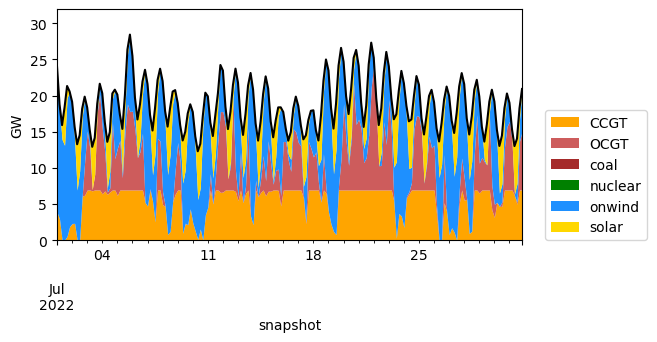

In [40]:
plot_dispatch(n)